# Parameters

In [1]:
source_folder = 'data'
destination_folder = 'models'

# Libraries

In [19]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import numpy as np
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import seaborn as sns

In [4]:
print(torch.__version__)

1.5.0+cu101


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
df_frag_pairs_balanced = pd.read_csv('data/frag_pairs_balanced.csv')
df_enh_frags = df_frag_pairs_balanced.drop_duplicates(subset=['enhancer_name'])[['enhancer_name', 'enhancer_seq']].reset_index(drop=True)
df_pro_frags = df_frag_pairs_balanced.drop_duplicates(subset=['promoter_name'])[['promoter_name', 'promoter_seq']].reset_index(drop=True)

df_enh_frags.columns = ['label', 'text']
for i in range(len(df_enh_frags)):
    df_enh_frags.at[i, 'text'] = " ".join(df_enh_frags.at[i, 'text'])
    df_enh_frags.at[i, 'label'] = 1

df_pro_frags.columns = ['label', 'text']
for i in range(len(df_pro_frags)):
    df_pro_frags.at[i, 'text'] = " ".join(df_pro_frags.at[i, 'text'])
    df_pro_frags.at[i, 'label'] = 0

first_column = df_enh_frags.pop('text')
df_enh_frags.insert(0, 'text', first_column)

first_column = df_pro_frags.pop('text')
df_pro_frags.insert(0, 'text', first_column)
    
display(df_enh_frags.head())
display(df_pro_frags.head())
print('{} enhancers - {} promoters'.format(len(df_enh_frags), len(df_enh_frags)))

,text,label
0,T T G C C T A A A C A C A G G C C A A G G G T ...,1
1,A A G G C A G A G T G T G A G G G G G T C A G ...,1
2,G C T C C C A G C T C T G G A T C G A G G C C ...,1
3,G T T T G C T A C T G T G C C C A A C T C C A ...,1
4,A G C T G G G A T T A C A G G C A T G A G C C ...,1


,text,label
0,A A C C C A G G A G G T G G A G G T T G C A G ...,0
1,C C A G G C T T C C C G A T T C C T C A C C T ...,0
2,A T A T C T G C T A T G T T C T G G C T C T T ...,0
3,C T C T C T C C T A T C T T G T A C G A T C T ...,0
4,C A G C C C T G A G A T C A C C T A A A A A G ...,0


3189 enhancers - 3189 promoters


# BALANCED TRAIN/TEST SPLIT 

In [8]:
df_enh_train, df_enh_test = train_test_split(df_enh_frags, test_size=0.1, random_state=42)
df_pro_train, df_pro_test = train_test_split(df_pro_frags, test_size=0.1, random_state=42)

df_train_dev = df_enh_train.append(df_pro_train).sample(frac=1).reset_index(drop=True) # append and shuffle
df_test = df_enh_test.append(df_pro_test).sample(frac=1).reset_index(drop=True) # append and shuffle

print(len(df_train_dev), 'train fragments and', len(df_test), 'test fragments')

5740 train fragments and 638 test fragments


In [9]:
# Model parameter

PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False,
                   include_lengths=False, batch_first=True,
                   pad_token=PAD_INDEX, unk_token=UNK_INDEX)

fields = [('text', text_field), ('label', label_field)]


df_train, df_dev = train_test_split(df_train_dev, test_size=0.1, random_state=42, shuffle=True)

df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)

df_train.to_csv("data/train.csv", index=False)
df_dev.to_csv("data/dev.csv", index=False)
df_test.to_csv("data/test.csv", index=False)

print(len(df_train), "train", len(df_dev), "dev", len(df_test), "test")

display(df_train.head())
display(df_dev.head())
display(df_test.head())

5166 train 574 dev 638 test


,text,label
0,A G G T T C C A C A C T A A G T G T G G G G T ...,1
1,T A T C T A A G A G T A G C T A T T G G C A C ...,0
2,T C C A C C C A C C T C G G T C C C C C A A A ...,0
3,C T T A C A T T A C G A A C A T T G G C A G A ...,1
4,T G T G C G G G T T G G A G T T C G G G A A G ...,0


,text,label
0,C G C C C T T T T T T A T T A A G C A T G A C ...,0
1,G G A C A G G C T G C A T C A A A G C C C T C ...,1
2,G A A A T A C T G A A G T G T G A G T C T T T ...,1
3,G C G C C C T C C G T C T C C T G C C T C G T ...,1
4,T G C C C A G A T A A T A A G T C G C C A A A ...,0


,text,label
0,T A A C A C A A G G T T T C A T T C T G T C C ...,0
1,A A T A A A A A A T G T T T A T A C A A T G A ...,0
2,C G A C C G G G C C A G G C C C C C G C A T G ...,0
3,C C C A T T G C C A C C C T C C C A G A G C G ...,1
4,T A A G T C T T C T T A G T A T G C A T A A A ...,0


In [10]:
train, dev, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='dev.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

In [11]:
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
dev_iter = BucketIterator(dev, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

# Models

In [12]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, seq_fea = self.encoder(text, labels=label)[:2]

        return loss, seq_fea

# Training

In [13]:
# Save and Load Functions

def save_checkpoint(save_path, model, dev_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'dev_loss': dev_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['dev_loss']


def save_metrics(save_path, train_loss_list, dev_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'dev_loss_list': dev_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['dev_loss_list'], state_dict['global_steps_list']

In [20]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          dev_loader = dev_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_dev_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    dev_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    dev_loss_list = []
    global_steps_list = []
    
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (texts, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            texts = texts.type(torch.LongTensor)  
            texts = texts.to(device)
            output = model(texts, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # dev loop
                    for (texts, labels), _ in dev_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        texts = texts.type(torch.LongTensor)  
                        texts = texts.to(device)
                        output = model(texts, labels)
                        loss, _ = output
                        
                        dev_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_dev_loss = dev_running_loss / len(dev_loader)
                train_loss_list.append(average_train_loss)
                dev_loss_list.append(average_dev_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                dev_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Dev Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_dev_loss))
                
                # checkpoint
                if best_dev_loss > average_dev_loss:
                    best_dev_loss = average_dev_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_dev_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, dev_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, dev_loss_list, global_steps_list)
    print('Finished Training!')

In [21]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
train(model=model, optimizer=optimizer)

Epoch [1/5], Step [161/1615], Train Loss: 0.6397, Dev Loss: 0.6268
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [1/5], Step [322/1615], Train Loss: 0.6142, Dev Loss: 0.5884
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [2/5], Step [483/1615], Train Loss: 0.5663, Dev Loss: 0.5789
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [2/5], Step [644/1615], Train Loss: 0.5636, Dev Loss: 0.5627
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [3/5], Step [805/1615], Train Loss: 0.5507, Dev Loss: 0.5852
Epoch [3/5], Step [966/1615], Train Loss: 0.5511, Dev Loss: 0.5569
Model saved to ==> models/model.pt
Model saved to ==> models/metrics.pt
Epoch [4/5], Step [1127/1615], Train Loss: 0.5525, Dev Loss: 0.5787
Epoch [4/5], Step [1288/1615], Train Loss: 0.5459, Dev Loss: 0.5572
Epoch [5/5], Step [1449/1615], Train Loss: 0.5367, Dev Loss: 0.5685
Epoch [5/5], Step [1610/1615], Tra

Model loaded from <== models/metrics.pt


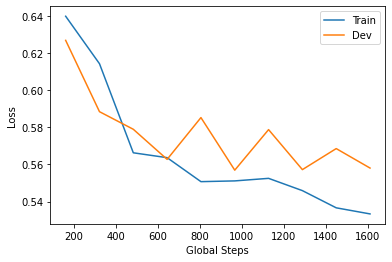

In [23]:
train_loss_list, dev_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, dev_loss_list, label='Dev')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [25]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (texts, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                texts = texts.type(torch.LongTensor)  
                texts = texts.to(device)
                output = model(texts, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['ENHANCER', 'PROMOTER'])
    ax.yaxis.set_ticklabels(['ENHANCER', 'PROMOTER'])

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
    print("AUC=", metrics.auc(fpr, tpr))

In [26]:
best_model = BERT().to(device)
load_checkpoint(destination_folder + '/model.pt', best_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== models/model.pt


0.5569154678119553

Classification Report:
              precision    recall  f1-score   support

           1     0.6634    0.8464    0.7438       319
           0     0.7879    0.5705    0.6618       319

    accuracy                         0.7085       638
   macro avg     0.7256    0.7085    0.7028       638
weighted avg     0.7256    0.7085    0.7028       638

AUC= 0.7084639498432601


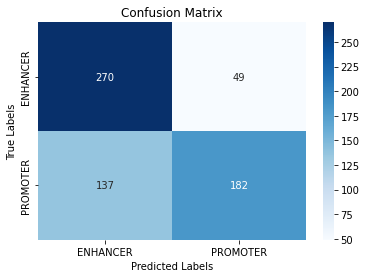

In [27]:
evaluate(best_model, test_iter)